In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from joblib import load, dump

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_train_tokenized.csv', encoding='utf-8-sig')
val_df   = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_val_tokenized.csv', encoding=' utf-8-sig')
test_df  = pd.read_csv('../BOW_PROJECT/tokenized/khmer_news_test_tokenized.csv', encoding='utf-8-sig')

In [3]:
print(f"  - train_tokenized.csv ({len(train_df)} samples)")
print(f"  - val_tokenized.csv ({len(val_df)} samples)")
print(f"  - test_tokenized.csv ({len(test_df)} samples)")

  - train_tokenized.csv (5140 samples)
  - val_tokenized.csv (661 samples)
  - test_tokenized.csv (1543 samples)


In [4]:
X_train_text = train_df['content']
y_train = train_df['label']

X_val_text = val_df['content']
y_val = val_df['label']

X_test_text = test_df['content']
y_test = test_df['label']

# **TF-IDF Vectorization**

In [5]:
tf_idf = TfidfVectorizer(
    analyzer=str.split,
    max_features=None,      #max_features is NOT required when using TruncatedSVD ✔ Let SVD control dimensionality
    min_df=3,
    max_df=0.85,
    ngram_range=(1, 2)
)

X_train_tf_idf = tf_idf.fit_transform(train_df['content'])
X_val_tf_idf  = tf_idf.transform(val_df['content'])
X_test_tf_idf  = tf_idf.transform(test_df['content'])

print(f"Vocabulary size: {len(tf_idf.vocabulary_):,}")
print(f"tf_idf shape (train): {X_train_tf_idf.shape}")
print(f"tf_idf shape (val): {X_val_tf_idf.shape}")
print(f"tf_idf shape (test): {X_test_tf_idf.shape}")

Vocabulary size: 13,222
tf_idf shape (train): (5140, 13222)
tf_idf shape (val): (661, 13222)
tf_idf shape (test): (1543, 13222)


In [6]:
import numpy as np

LABEL_MAP = {
    0: "economic",
    1: "entertainment",
    2: "life",
    3: "politic",
    4: "sport",
    5: "technology"
}
feature_names = np.array(tf_idf.get_feature_names_out())
TOP_N = 10

print("=" * 80)
print("TOP TF-IDF TERMS PER CATEGORY")
print("=" * 80)

for label_id, label_name in LABEL_MAP.items():

    # select documents belonging to this class
    pos_mask = (y_train == label_id).to_numpy()
    pos_count = pos_mask.sum()

    print(f"\n{label_name.upper():<12}")

    if pos_count == 0:
        print("No samples")
        continue

    # mean TF-IDF vector for the class
    class_mean_tfidf = np.asarray(
        X_train_tf_idf[pos_mask].mean(axis=0)
    ).ravel()

    # top-N terms
    top_indices = np.argsort(class_mean_tfidf)[-TOP_N:][::-1]

    print("-" * 50)
    print(f"Samples: {pos_count}")
    print("-" * 50)

    for rank, idx in enumerate(top_indices, start=1):
        term = feature_names[idx]
        score = class_mean_tfidf[idx]
        print(f"{rank:2}. {term:<25} {score:.6f}")

TOP TF-IDF TERMS PER CATEGORY

ECONOMIC    
--------------------------------------------------
Samples: 851
--------------------------------------------------
 1. កម្ពុជា                   0.086050
 2. លោក                       0.065491
 3. ប្រទេស                    0.062549
 4. ក្រុមហ៊ុន                 0.053861
 5. ពាណិជ្ជកម្ម               0.052451
 6. សេដ្ឋកិច្ច                0.049613
 7. ភាគរយ                     0.049018
 8. ឆ្នាំ                     0.048238
 9. លាន                       0.043406
10. ដុល្លារ                   0.043199

ENTERTAINMENT
--------------------------------------------------
Samples: 700
--------------------------------------------------
 1. នាង                       0.072710
 2. តារា                      0.055329
 3. ជា                        0.048213
 4. រឿង                       0.043206
 5. លោក                       0.039212
 6. សម្តែង                    0.036842
 7. ពី                        0.034102
 8. មិន                       0.033582
 9. ភាពយន

## Train Classifiers with Class Imbalance Handling

In [21]:
# =========================================================
# Build classifiers function
# =========================================================
def build_classifiers(random_state: int = 42):
    """
    Build a dictionary of classifiers for BoW + PCA text classification.
    """
    models = {}

    # Logistic Regression
    models["logistic"] = LogisticRegression(
        penalty="l2",
        C=0.8,
        solver="liblinear",
        max_iter=2000,
        class_weight="balanced",
        random_state=random_state
    )

    # Linear SVM
    models["svm"] = LinearSVC(
        C=0.1,
        loss="squared_hinge",
        class_weight="balanced",
        max_iter=3000,
        random_state=random_state
    )

    # Random Forest
    models["random_forest"] = RandomForestClassifier(
        n_estimators=400,
        max_depth=25,
        min_samples_split=4,
        min_samples_leaf=2,
        class_weight="balanced",
        n_jobs=-1,
        random_state=random_state
    )

    # XGBoost
    models["xgboost"] = XGBClassifier(
        n_estimators=600,
        learning_rate=0.07,
        max_depth=6,
        subsample=0.85,
        colsample_bytree=0.85,
        objective="multi:softmax",
        num_class=6,
        eval_metric="mlogloss",
        tree_method="hist",
        n_jobs=-1,
        random_state=random_state
    )

    return models

In [22]:
# =========================================================
# Train and evaluate classifier TF-IDF with all features
# =========================================================
from sklearn.metrics import f1_score, classification_report

label_cols = ['economic', 'entertainment', 'life', 'politic', 'sport', 'technology']
results = {}

print("\nTraining and evaluating models (TF-IDF)...\n")

classifiers = build_classifiers(random_state=42)

for model_name, model in classifiers.items():
    print(f"→ Training {model_name}...")

    # Fit model on tf-idf training data
    model.fit(X_train_tf_idf, y_train)

    # Predict on validation set
    y_pred = model.predict(X_val_tf_idf)

    # Compute macro F1 score
    macro_f1 = f1_score(y_val, y_pred, average="macro", zero_division=0)
    results[model_name] = macro_f1

    # Print classification report
    print(f"{model_name} — Validation Macro F1: {macro_f1:.4f}")
    print(classification_report(
        y_val,
        y_pred,
        target_names=label_cols,
        zero_division=0
    ))
    print("-" * 60)

# =========================================================
# Summary of results
# =========================================================
print("\nValidation Macro F1 scores for all models:")
for model_name, score in results.items():
    print(f"{model_name}: {score:.4f}")


Training and evaluating models (TF-IDF)...

→ Training logistic...
logistic — Validation Macro F1: 0.9041
               precision    recall  f1-score   support

     economic       0.87      0.87      0.87       109
entertainment       0.98      0.91      0.94        90
         life       0.77      0.83      0.80        90
      politic       0.93      0.96      0.95       192
        sport       0.97      0.97      0.97        90
   technology       0.94      0.86      0.90        90

     accuracy                           0.91       661
    macro avg       0.91      0.90      0.90       661
 weighted avg       0.91      0.91      0.91       661

------------------------------------------------------------
→ Training svm...
svm — Validation Macro F1: 0.9204
               precision    recall  f1-score   support

     economic       0.89      0.91      0.90       109
entertainment       0.98      0.94      0.96        90
         life       0.83      0.83      0.83        90
      

Plotting confusion matrices using: svm


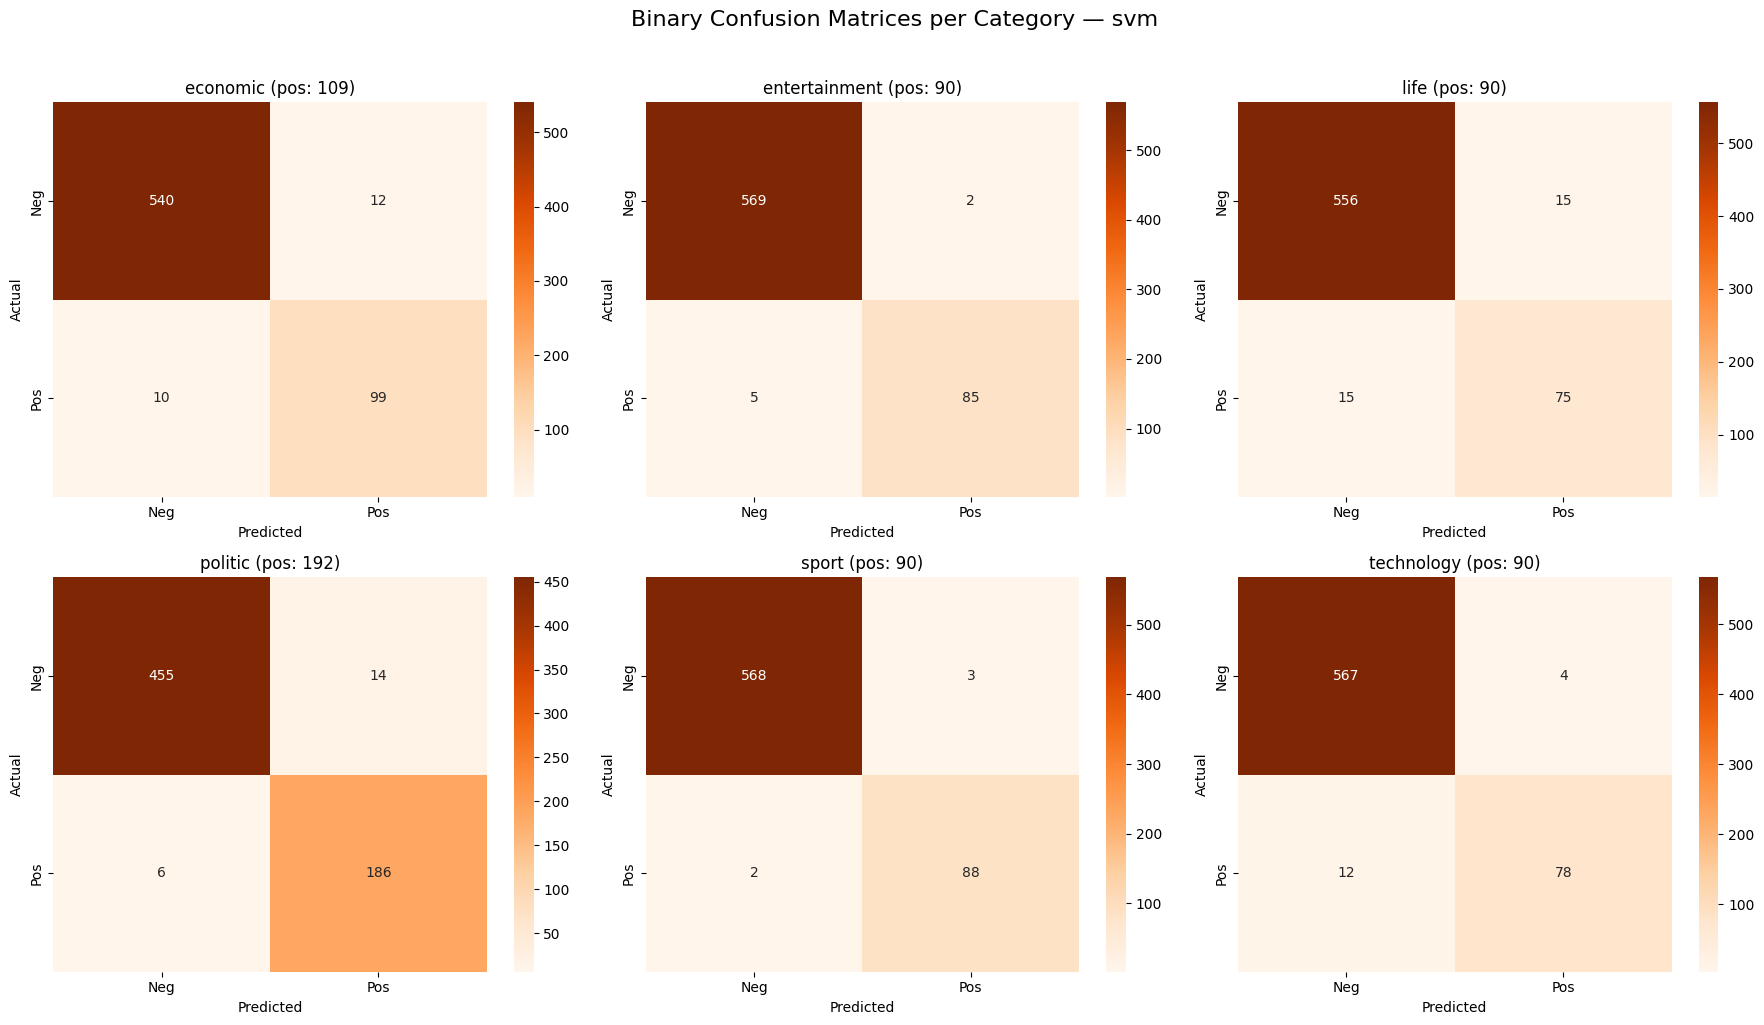

In [23]:
best_model_name = max(results, key=results.get)
best_clf = classifiers[best_model_name]

# Predict using original features 
y_pred_best = best_clf.predict(X_val_tf_idf)

print(f"Plotting confusion matrices using: {best_model_name}")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    # Convert to binary: 1 if this class, 0 otherwise
    y_true_bin = (y_val == i).astype(int)
    y_pred_bin = (y_pred_best == i).astype(int)

    cm = confusion_matrix(y_true_bin, y_pred_bin)

    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Oranges', ax=axes[i],
        xticklabels=['Neg','Pos'], yticklabels=['Neg','Pos']
    )
    axes[i].set_title(f"{label} (pos: {y_true_bin.sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Binary Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [24]:
print("\n" + "="*80)
print(f"STEP 1: TEST SET EVALUATION - {best_model_name}")
print("="*80)

# Predict on TEST set (NO PCA)
y_pred_test = best_clf.predict(X_test_tf_idf)

test_macro_f1 = f1_score(
    y_test,
    y_pred_test,
    average='macro',
    zero_division=0
)

print(f"\nTest Macro F1: {test_macro_f1:.4f}")
print("\n" + classification_report(
    y_test,
    y_pred_test,
    target_names=label_cols,
    zero_division=0
))


STEP 1: TEST SET EVALUATION - svm

Test Macro F1: 0.9111

               precision    recall  f1-score   support

     economic       0.87      0.89      0.88       256
entertainment       0.94      0.94      0.94       210
         life       0.84      0.75      0.80       210
      politic       0.96      0.96      0.96       449
        sport       0.95      0.99      0.97       209
   technology       0.90      0.94      0.92       209

     accuracy                           0.92      1543
    macro avg       0.91      0.91      0.91      1543
 weighted avg       0.92      0.92      0.92      1543




Test Set Confusion Matrices per Category


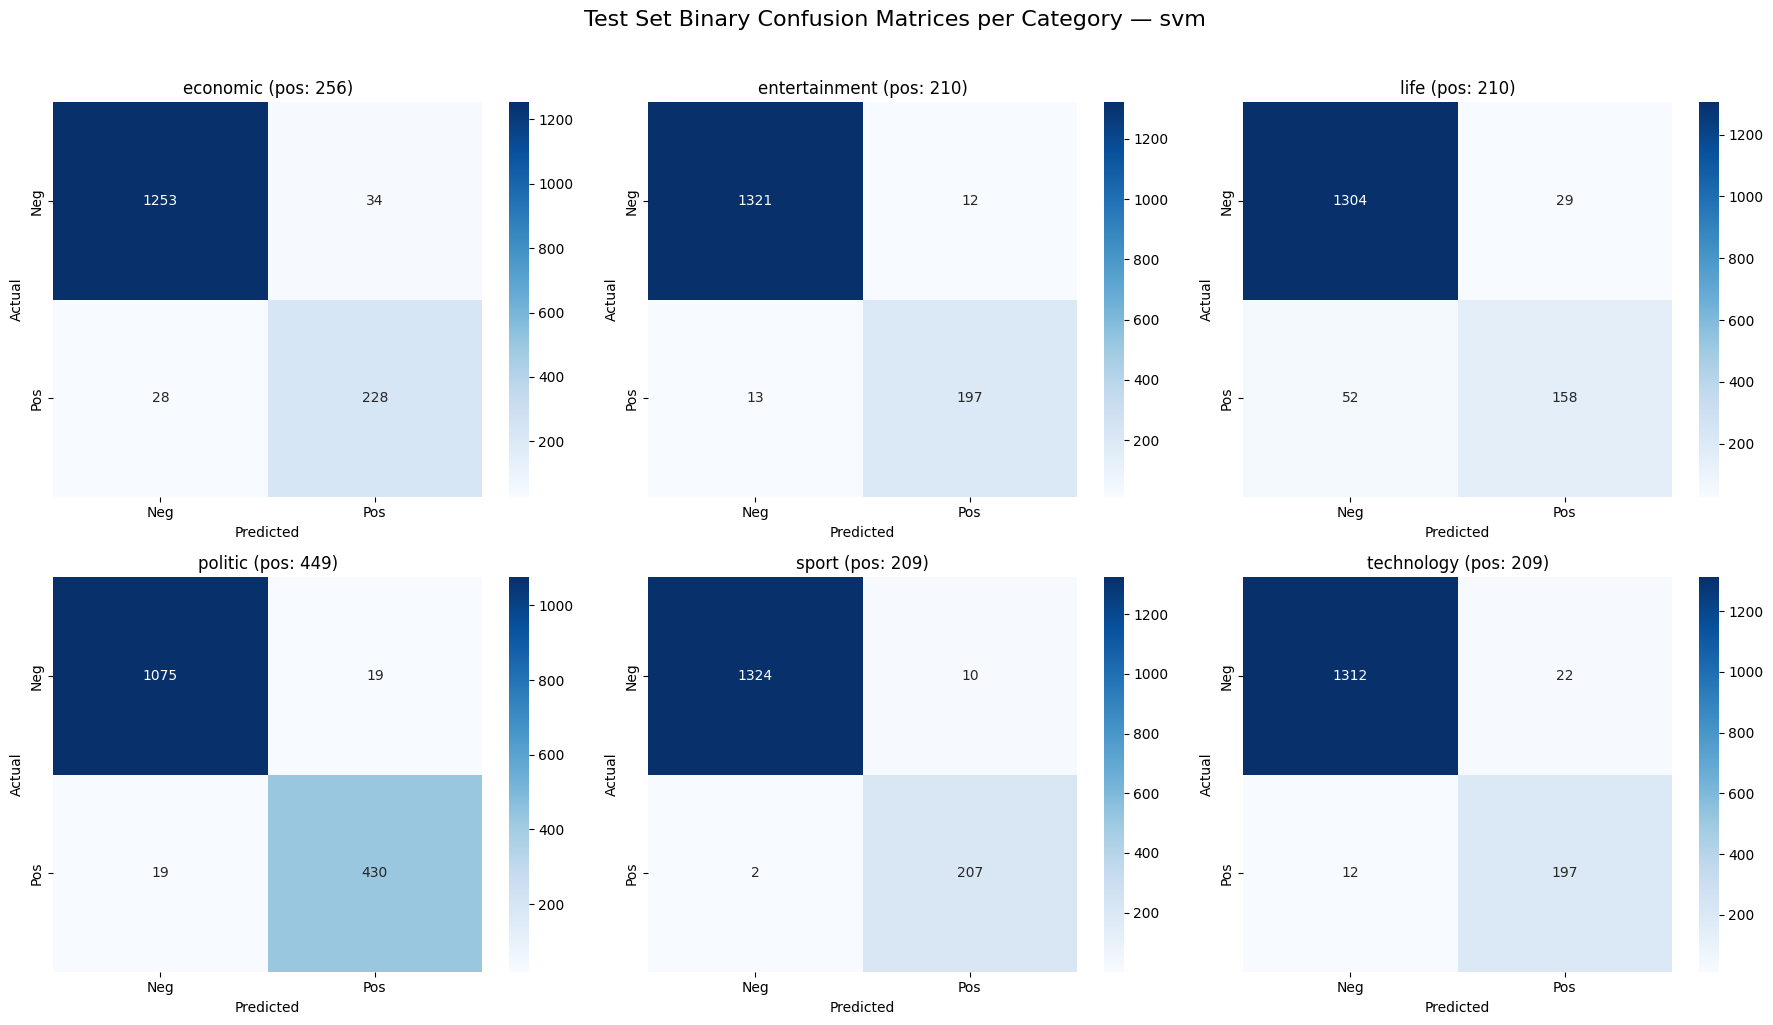

In [25]:
print("\n" + "="*80)
print("Test Set Confusion Matrices per Category")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i, label in enumerate(label_cols):
    # Binary: 1 if current class, else 0
    y_true_bin = (y_test == i).astype(int)
    y_pred_bin = (y_pred_test == i).astype(int)
    
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        ax=axes[i],
        xticklabels=['Neg', 'Pos'],
        yticklabels=['Neg', 'Pos']
    )
    
    axes[i].set_title(f"{label} (pos: {y_true_bin.sum()})")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.suptitle(f"Test Set Binary Confusion Matrices per Category — {best_model_name}", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Saving & Loading model

In [26]:
import os
from joblib import dump

save_dir = '../BOW_PROJECT/models/tfidf_with_all_feature'
os.makedirs(save_dir, exist_ok=True)

dump(classifiers["logistic"], f'{save_dir}/logistic_regression_model.joblib')
dump(classifiers["svm"], f'{save_dir}/linear_svm_model.joblib')
dump(classifiers["random_forest"], f'{save_dir}/random_forest_model.joblib')
dump(classifiers["xgboost"], f'{save_dir}/xgboost_model.joblib')

# Also save the CountVectorizer
dump(tf_idf, f'{save_dir}/tf_idf_vectorizer.joblib')

# Save class labels for inference
import pandas as pd
pd.DataFrame(label_cols, columns=["label"]).to_csv(f'{save_dir}/classes.csv', index=False)

print("✅ Models and preprocessors saved successfully!")

✅ Models and preprocessors saved successfully!


## Testing

In [27]:
import re
import numpy as np
import pandas as pd
from joblib import load
from khmernltk import word_tokenize  # make sure khmer-nltk is installed

# -----------------------------
# 1. Load saved objects
# -----------------------------
tf_idf = load('../BOW_PROJECT/models/tfidf_with_all_feature/tf_idf_vectorizer.joblib')
model     = load('../BOW_PROJECT/models/tfidf_with_all_feature/linear_svm_model.joblib')
classes   = pd.read_csv('../BOW_PROJECT/models/tfidf_with_all_feature/classes.csv')['label'].tolist()

# -----------------------------
# 2. Preprocessing functions
# -----------------------------
def clean_khmer_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    text = re.sub(r'<[^>]+>', '', text)                    # remove HTML
    text = re.sub(r'[\u200B-\u200D\uFEFF]', '', text)      # zero-width chars
    text = re.sub(r'[!"#$%&\'()*+,—./:;<=>?@[\]^_`{|}~។៕៖ៗ៘៙៚៛«»-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def khmer_tokenize(text: str) -> str:
    """
    Clean and tokenize Khmer text using khmer-nltk.
    Output is a SPACE-separated token string
    (required for CountVectorizer(analyzer=str.split))
    """
    cleaned = clean_khmer_text(text)
    if not cleaned:
        return ""

    tokens = word_tokenize(cleaned, return_tokens=True)
    tokens = [tok for tok in tokens if tok.strip()]
    return " ".join(tokens)

# -----------------------------
# 3. Prediction function
# -----------------------------
def predict_khmer_text(text: str):
    # Preprocess
    tokenized_text = khmer_tokenize(text)
    if not tokenized_text:
        return "No valid text to predict"

    # tf-idf transform
    tf_idf_vec = tf_idf.transform([tokenized_text])

    # Predict (multi-class)
    pred = model.predict(tf_idf_vec)   # shape: (1,)
    class_index = int(pred[0])
    return classes[class_index]

# -----------------------------
# 4. Test
# -----------------------------
new_text = """
រដ្ឋាភិបាលជប៉ុន សូមស្វាគមន៍លទ្ធផលកិច្ចប្រជុំគណៈកម្មាធិការព្រំដែនទូទៅ
រវាងកម្ពុជា និងថៃ ដែលបានធ្វើឡើងនៅម៉ាឡេស៊ី នៅថ្ងៃទី២៣ ខែតុលា។
នេះបើតាមសេចក្តីថ្លែងការណ៍របស់លោក Kitamura Toshihiro
អ្នកនាំពាក្យក្រសួងការបរទេសជប៉ុន។
"""

predicted_category = predict_khmer_text(new_text)
print("Predicted category:", predicted_category)

Predicted category: politic


In [28]:
print(khmer_tokenize(new_text))

រដ្ឋាភិបាល ជប៉ុន សូមស្វាគមន៍ លទ្ធផល កិច្ចប្រជុំ គណៈកម្មាធិការ ព្រំដែន ទូទៅ រវាង កម្ពុជា និង ថៃ ដែល បាន ធ្វើឡើង នៅ ម៉ាឡេស៊ី នៅ ថ្ងៃទី ២៣ ខែតុលា នេះ បើ តាម សេចក្តីថ្លែងការណ៍ របស់ លោក Kitamura Toshihiro អ្នកនាំពាក្យ ក្រសួង ការបរទេស ជប៉ុន
